In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 24, 24

# read map data

In [3]:
filename = 'colliders.csv'
data = np.loadtxt(filename,delimiter=',',dtype='Float64',skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [4]:
data.shape

(3845, 6)

In [5]:
np.floor(np.amin(data[:, 0] - data[:, 3])), np.ceil(np.amax(data[:, 0] + data[:, 3]))

(-316.0, 605.0)

In [6]:
np.floor(np.amin(data[:, 1] - data[:, 4])), np.ceil(np.amax(data[:, 1] + data[:, 4]))

(-445.0, 476.0)

In [7]:
np.floor(np.amin(data[:, 2] - data[:, 5])), np.ceil(np.amax(data[:, 2] + data[:, 5]))

(-1.0, 212.0)

# read start position

In [8]:
with open(filename) as f:
    for line in f:
        break
(_, start_lat, _, start_lon) = line.split()
start_lat = float(start_lat.strip(','))
start_lon = float(start_lon.strip(','))

In [9]:
print (start_lat, start_lon)

37.79248 -122.39745


# plan using A*

In [10]:
from planning_utils import a_star, heuristic, create_grid, Action

In [11]:
# Static drone altitude (metres)
drone_altitude = 5
# Minimum distance required to stay away from an obstacle (metres)
safe_distance = 5

In [12]:
%time grid, n_offset, e_offset = create_grid(data, drone_altitude, safe_distance)

CPU times: user 100 ms, sys: 6.28 ms, total: 106 ms
Wall time: 105 ms


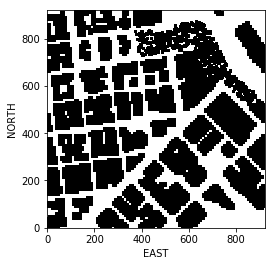

In [13]:
plt.imshow(grid, cmap='Greys', origin='lower') 
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [14]:
start_ne = (316, 445)
goal_ne = (539, 138)

In [15]:
%time path, cost = a_star(grid, heuristic, start_ne, goal_ne)
print(len(path), cost)

Found a path.
CPU times: user 5.12 s, sys: 428 ms, total: 5.55 s
Wall time: 6.25 s
451 83461.79060689172


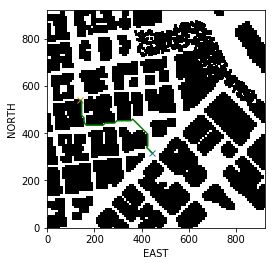

In [16]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [17]:
def collinearity_3D(p1, p2, p3, epsilon=1e-6): 
    collinear = False
    mat = np.vstack((p1, p2, p3))
    det = np.linalg.det(mat)
    if det < epsilon:
        collinear = True
    return collinear

In [18]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

In [19]:
def collinearity_2D(p1, p2, p3, epsilon=1e-6): 
    collinear = False
    det = p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1] - p1[1]) + p3[0]*(p1[1] - p2[1])
    if abs(det) < epsilon:
        collinear = True
    return collinear

In [20]:
# using collinearity here, but could use Bresenham as well
def prune_path(path):
    pruned_path = [p for p in path]
    i = 0
    while i < len(pruned_path) - 2:
        p1 = (pruned_path[i])
        p2 = (pruned_path[i+1])
        p3 = (pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_2D(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [21]:
pruned_path = prune_path(path)
print(len(pruned_path))

22


In [22]:
print(pruned_path)

[(316, 445), (340, 421), (341, 421), (346, 426), (396, 426), (460, 362), (453, 355), (453, 295), (443, 285), (443, 245), (434, 236), (434, 166), (442, 158), (448, 158), (450, 156), (466, 156), (476, 146), (536, 146), (537, 145), (537, 143), (539, 141), (539, 138)]


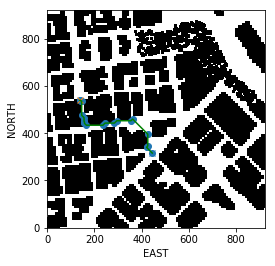

In [23]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [ ]:
from bresenham import bresenham

In [ ]:
[p for p in bresenham(1,1,7,12)]

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
points = np.random.randint(50, size=(50, 2))
graph = Voronoi(points)

In [ ]:
graph

In [ ]:
len(graph.ridge_vertices)

In [ ]:
graph.ridge_vertices[0]

In [ ]:
graph.vertices[1]

In [ ]:
voronoi_plot_2d(graph)
plt.show()

In [ ]:
def create_grid_and_edges(data, drone_altitude, safety_distance=0):
    """
    expects map data in format (x,y,z,dx,dy,dz) where d_ is half size in that direction, x is obstacle mid-point
    
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    Also returns Voronoi graph around obstacles.
    """
    xind = 0
    yind = 2
    zind = 1

    # minimum and maximum north coordinates
    north_min = np.floor(np.amin(data[:, xind] - data[:, xind+3]))
    north_max = np.ceil(np.amax(data[:, xind] + data[:, xind+3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.amin(data[:, yind] - data[:, yind+3]))
    east_max = np.ceil(np.amax(data[:, yind] + data[:, yind+3]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min)))
    east_size = int(np.ceil((east_max - east_min)))

    grid = np.zeros((north_size, east_size))
    points = [] # centers of obstacles

    for i in range(data.shape[0]):
        pt = data[i, :]
        north = pt[xind]
        east = pt[yind]
        alt = pt[zind]
        d_north = pt[xind+3]
        d_east = pt[yind+3]
        d_alt = pt[zind+3]

        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(north - d_north - safety_distance - north_min),
                int(north + d_north + safety_distance - north_min),
                int(east - d_east - safety_distance - east_min),
                int(east + d_east + safety_distance - east_min),
            ]
            grid[obstacle[0]:obstacle[1], obstacle[2]:obstacle[3]] = 1
            # add center of obstacles to points list
            points.append([north - north_min, east - east_min])

    # create a voronoi graph based on location of obstacle centres
    graph = Voronoi(points)
            
    # check each edge from graph.ridge_vertices for collision
    edges = []
    for v in graph.ridge_vertices:
        p1 = graph.vertices[v[0]]
        p2 = graph.vertices[v[1]]
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit = False

        for c in cells:
            # First check if we're off the map
            if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                hit = True
                break
            # Next check if we're in collision
            if grid[c[0], c[1]] == 1:
                hit = True
                break

        # If the edge does not hit on obstacle
        # add it to the list
        if not hit:
            # array to tuple for future graph creation step)
            p1 = (p1[0], p1[1])
            p2 = (p2[0], p2[1])
            edges.append((p1, p2))

    return grid, edges


In [ ]:
drone_altitude = 3
%time grid, edges = create_grid_and_edges(data, drone_altitude)
print('Found %5d edges' % len(edges))

In [ ]:
# show grid/obstacles
plt.imshow(grid, origin='lower', cmap='Greys') 
# Voronoi graph edge by edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
# start and finish
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')    
# labels
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [ ]:
import networkx as nx
import numpy.linalg as LA

In [ ]:
# create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()
for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)

In [ ]:
def heuristic(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1))

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 
4. Plot it up to see the results!

In [ ]:
def a_star_graph(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

In [ ]:
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

In [ ]:
start_ne_g = closest_point(G, start_ne)
goal_ne_g = closest_point(G, goal_ne)
print(start_ne_g)
print(goal_ne_g)

In [ ]:
%time path, cost = a_star_graph(G, heuristic, start_ne_g, goal_ne_g)
print(len(path))

In [ ]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')
    
plt.plot(start_ne[1], start_ne[0], 'gx')
plt.plot(goal_ne[1], goal_ne[0], 'gx')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()

In [ ]:
from skimage.morphology import medial_axis
from skimage.util import invert

In [ ]:
# The medial_axis() method requires that we invert the grid image
skeleton = medial_axis(invert(grid))

In [ ]:
skeleton

In [ ]:
plt.imshow(grid, origin='lower')
plt.imshow(skeleton, origin='lower', cmap='Greys', alpha=0.7)
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')
plt.show()

In [ ]:
def find_start_goal(skel, start, goal):
    skel_cells = np.transpose(skeleton.nonzero())
    start_min_dist = np.linalg.norm(np.array(start) - np.array(skel_cells), axis=1).argmin()
    near_start = skel_cells[start_min_dist]
    goal_min_dist = np.linalg.norm(np.array(goal) - np.array(skel_cells), axis=1).argmin()
    near_goal = skel_cells[goal_min_dist]
    return near_start, near_goal

In [ ]:
skel_start, skel_goal = find_start_goal(skeleton, start_ne, goal_ne)

print(start_ne, goal_ne)
print(skel_start, skel_goal)

In [ ]:
from enum import Enum
from queue import PriorityQueue


# Quadroter assume all actions cost the same.
class Action(Enum):
    """
    An action is represented by a 3 element tuple.

    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """

    WEST = (0, -1, 1)
    EAST = (0, 1, 1)
    NORTH = (-1, 0, 1)
    SOUTH = (1, 0, 1)
    NORTH_WEST = (-1, -1, 1)
    NORTH_EAST = (-1, 1, 1)
    SOUTH_WEST = (1, -1, 1)
    SOUTH_EAST = (1, 1, 1)

    @property
    def cost(self):
        return self.value[2]

    @property
    def delta(self):
        return (self.value[0], self.value[1])


def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid_actions = list(Action)
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node

    # check if the node is off the grid or
    # it's an obstacle

    if x - 1 < 0 or grid[x - 1, y] == 1:
        valid_actions.remove(Action.NORTH)
    if x + 1 > n or grid[x + 1, y] == 1:
        valid_actions.remove(Action.SOUTH)
    if y - 1 < 0 or grid[x, y - 1] == 1:
        valid_actions.remove(Action.WEST)
    if y + 1 > m or grid[x, y + 1] == 1:
        valid_actions.remove(Action.EAST)

    if (x - 1 < 0 and y - 1 < 0) or grid[x - 1, y - 1] == 1:
        valid_actions.remove(Action.NORTH_WEST)
    if (x - 1 < 0 and y + 1 > m) or grid[x - 1, y + 1] == 1:
        valid_actions.remove(Action.NORTH_EAST)
    if (x + 1 > n and y - 1 < 0) or grid[x + 1, y - 1] == 1:
        valid_actions.remove(Action.SOUTH_WEST)
    if (x + 1 > n and y + 1 > m) or grid[x + 1, y + 1] == 1:
        valid_actions.remove(Action.SOUTH_EAST)

    return valid_actions


def a_star(grid, heuristic_func, start, goal):
    """
    Given a grid and heuristic function returns
    the lowest cost path from start to goal.
    """

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False

    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:
            print('Found a path.')
            found = True
            break
        else:
            # Get the new vertexes connected to the current vertex
            for a in valid_actions(grid, current_node):
                next_node = (current_node[0] + a.delta[0], current_node[1] + a.delta[1])
                new_cost = current_cost + a.cost + heuristic_func(next_node, goal)

                if next_node not in visited:
                    visited.add(next_node)
                    queue.put((new_cost, next_node))

                    branch[next_node] = (new_cost, current_node, a)

    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])

    return path[::-1], path_cost

In [ ]:
def heuristic_func_eucl(position, goal_position):
    return np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2)

In [ ]:
# Run A* on the skeleton
%time path, cost = a_star(invert(skeleton).astype(np.int), heuristic_func_eucl, tuple(skel_start), tuple(skel_goal))
print("Path length = {0}, path cost = {1}".format(len(path), cost))

In [ ]:
# PRUNE the path!

In [ ]:
# Compare to regular A* on the grid
%time path2, cost2 = a_star(grid, heuristic_func_eucl, start_ne, goal_ne)
print("Path length = {0}, path cost = {1}".format(len(path2), cost2))

In [ ]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
pp2 = np.array(path2)
plt.plot(pp2[:, 1], pp2[:, 0], 'r')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()